# Sensitivity analysis 
using OGGM edu glacier model
by Thomas Gölles, 2024

In [43]:
from oggm_edu import GlacierBed, Glacier, MassBalance, GlacierCollection
import SALib
from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze
import numpy as np

from matplotlib import pyplot as plt

print("salib version: ", SALib.__version__)

salib version:  1.4.7


## General OGGM definitions

In [44]:
# Lets define the bed.
# Top and bottom altitude.
top = 5000
bottom = 0
# How far does the accumulation area extend?
accumulation_fraction = 1 / 3
# ELA altitude
ela_alt = (top - bottom) * (1 - accumulation_fraction)
# Accumulation area starts out as 1000 m. wide.
top_width = 1000
# 500 m. wide after ELA.
ela_width = 500

# Bed, note that we increase the map_dx here,
# we increase the grid point spacing.
bed = GlacierBed(
    altitudes=[top, ela_alt, bottom],
    widths=[top_width, ela_width, ela_width],
    map_dx=200,
)

Lets investigate how the mass blance influences the volume

In [45]:
mb_gradient = 7
mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)

In [48]:
glacier = Glacier(bed, mass_balance=mass_balance)
glacier.progress_to_equilibrium()

In [49]:
glacier

,
Attribute,
Id,103
Type,Glacier
Age,127
Length [m],35600.0
Area [km2],21.15
Volume [km3],6.282884
Max ice thickness [m],342.297831
Max ice velocity [m/yr],902.8394591929571
AAR [%],53.664303


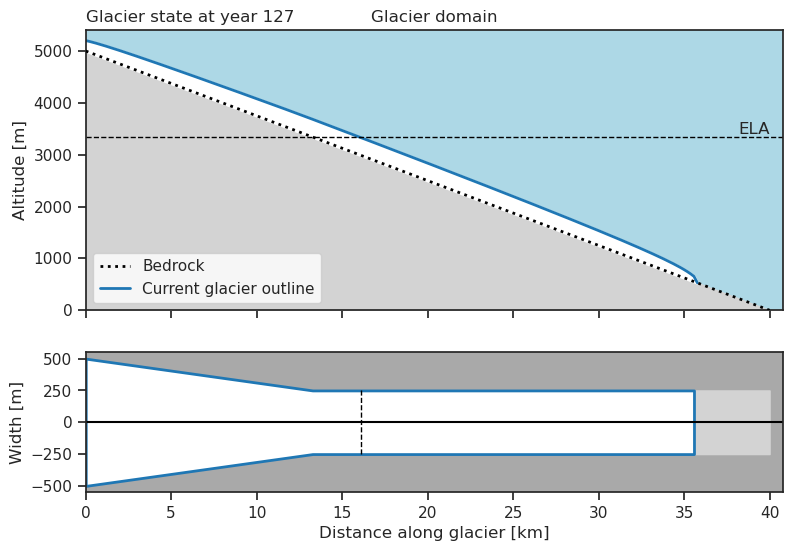

In [50]:
glacier.plot()

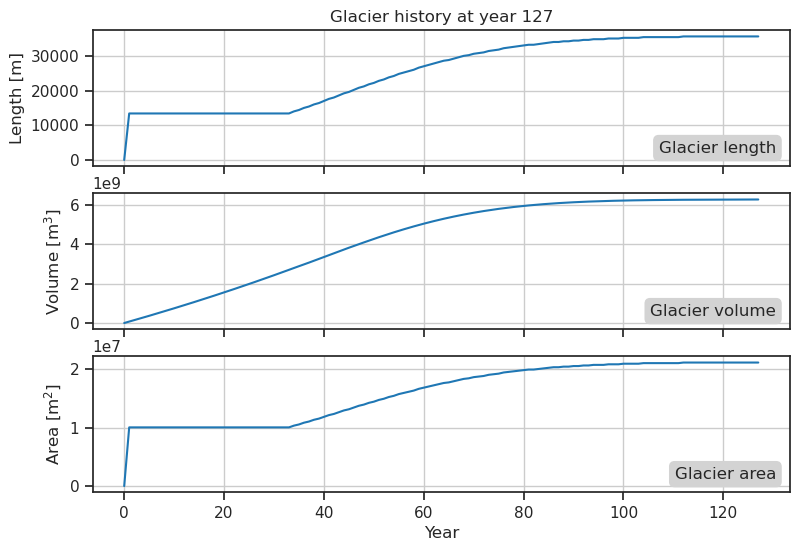

In [51]:
glacier.plot_history()

In [52]:
glacier.history

<xarray.Dataset>
Dimensions:           (time: 128)
Coordinates:
  * time              (time) float64 0.0 1.0 2.0 3.0 ... 124.0 125.0 126.0 127.0
    calendar_year     (time) int64 0 1 2 3 4 5 6 ... 121 122 123 124 125 126 127
    calendar_month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year        (time) int64 0 1 2 3 4 5 6 ... 121 122 123 124 125 126 127
    hydro_month       (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
Data variables:
    volume_m3         (time) float64 0.0 7.223e+07 ... 6.282e+09 6.283e+09
    volume_bsl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    volume_bwl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area_m2           (time) float64 0.0 1.005e+07 ... 2.115e+07 2.115e+07
    length_m          (time) float64 0.0 1.34e+04 1.34e+04 ... 3.56e+04 3.56e+04
    calving_m3        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    calving_rate_myr  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/13)
    description:          OGGM model output
    oggm_version:         1.6.1
    calendar:             365-day no leap
    creation_date:        2024-02-12 10:58:12
    water_level:          0
    glen_a:               2.4e-24
    ...                   ...
    mb_model_class:       MassBalance
    mb_model_hemisphere:  nh
    mb_model_rho:         900.0
    mb_model_orig_ela_h:  3333.3333333333335
    mb_model_ela_h:       3333.3333333333335
    mb_model_grad:        7

We need a function which takes the mb_graident and gives us the resulting glacier in quilibrium. Then we varay the massbalance gradient and analyse the outcome.

In [53]:
def evaluate_model(mb_gradient):
    mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)
    glacier = Glacier(bed, mass_balance=mass_balance)
    glacier.progress_to_equilibrium()
    return glacier

## OAT sensitivity analysis

We interessed in the equilibirum glacier volume. And we want to know how the glacier reacts to massbalance gadients form 0.01 to 10.

In [54]:
mb_gradient_min = 0.01
mb_gradient_max = 10
number_of_samples = 100
np.random.seed(0)  # so the results are reproducible and everyone gets the same results
mb_gradient_samples = np.random.uniform(
    mb_gradient_min, mb_gradient_max, number_of_samples
)
mb_gradient_samples

array([5.4926469 , 7.15474177, 6.03160613, 5.453383  , 4.24231145,
       6.46248219, 4.38149624, 8.91881228, 9.63699098, 3.84058077,
       7.91933313, 5.29366025, 5.68476517, 9.25671042, 0.71965022,
       0.8804217 , 0.21198179, 8.32787226, 7.78378594, 8.70142136,
       9.78639724, 7.99359406, 4.62017883, 7.80748647, 1.19156151,
       6.402811  , 1.44209934, 9.44724248, 5.22326473, 4.15247278,
       2.65291056, 7.74459456, 4.56694182, 5.68865515, 0.19771011,
       6.18017862, 6.12483627, 6.17317063, 9.4380433 , 6.82138479,
       3.60148393, 4.37594922, 6.97933565, 0.61165246, 6.67099949,
       6.70967232, 2.11172179, 1.29797371, 3.16112923, 3.6434706 ,
       5.70626574, 4.39162912, 9.88385464, 1.02942766, 2.09667879,
       1.62148208, 6.53455217, 2.54038311, 4.66844462, 2.45181166,
       1.59810614, 1.11264766, 6.5667326 , 1.39044768, 1.97385779,
       3.69356445, 8.21172237, 0.98004175, 8.38106963, 0.97002309,
       9.76483006, 4.6918255 , 9.76784327, 6.05240674, 7.39524

Ok, now we have the sample for our one one at the time sensitivity analysis.

Now lets generate a list with all the glaciers for the different mass balance gradients. We need an empty list to which we append the results run in a for loop:

In [55]:
results = []
for mb_gradient in mb_gradient_samples:
    glacier = evaluate_model(mb_gradient)
    results.append(glacier)
    print(f"Done with mb_gradient: {mb_gradient}")

Done with mb_gradient: 5.4926469042339745
Done with mb_gradient: 7.15474177006047
Done with mb_gradient: 6.031606126955722
Done with mb_gradient: 5.453382998138999
Done with mb_gradient: 4.242311445395658
Done with mb_gradient: 6.462482189535894
Done with mb_gradient: 4.381496240514298
Done with mb_gradient: 8.918812277812977
Done with mb_gradient: 9.636990977405283
Done with mb_gradient: 3.840580773069519
Done with mb_gradient: 7.919333130445819
Done with mb_gradient: 5.293660248331515
Done with mb_gradient: 5.6847651653283835
Done with mb_gradient: 9.256710416543683
Done with mb_gradient: 0.7196502213968906
Done with mb_gradient: 0.8804217040183917
Done with mb_gradient: 0.21198179042885396
Done with mb_gradient: 8.3278722570239
Done with mb_gradient: 7.783785941989006
Done with mb_gradient: 8.701421360985723
Done with mb_gradient: 9.786397238905312
Done with mb_gradient: 7.993594056525069
Done with mb_gradient: 4.620178828906789
Done with mb_gradient: 7.80748647110169
Done with mb_g

Now OGGM_edu has a usefull class called GlacierCollection

In [ ]:
ota_runs = GlacierCollection(results)

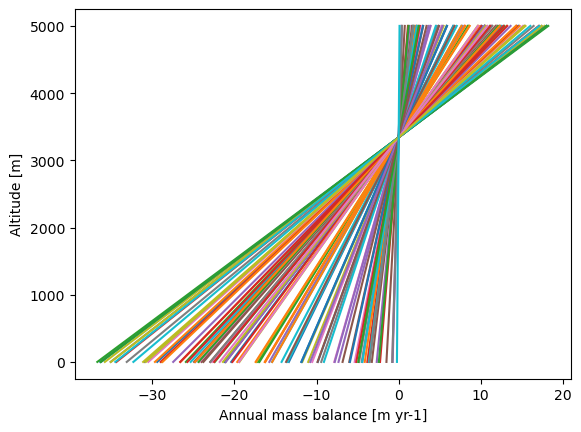

In [56]:
# plot mass balances
fig, ax = plt.subplots()
for glacier in ota_runs.glaciers:
    ax.plot(
        glacier.annual_mass_balance,
        glacier.bed.bed_h,
        label=f"Glacier {glacier.id}, " + f"gradient {glacier.mass_balance.gradient}",
    )
    # Add each ELA.
    # elas.append(glacier.mass_balance.ela)
    # Add labels.
    ax.set_xlabel("Annual mass balance [m yr-1]")
    ax.set_ylabel("Altitude [m]")

Now lets plot the equilibrium volume vs the mass balance gradient:

Text(0, 0.5, 'Volume [km3]')

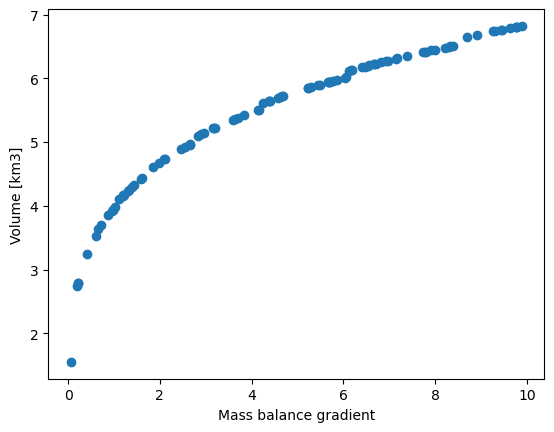

In [57]:
plt.scatter(mb_gradient_samples, ota_runs.summary()["Volume [km3]"])
plt.xlabel("Mass balance gradient")
plt.ylabel("Volume [km3]")

What do we see here?

* The volume depends on the mass balance gradient
* it is non-linear
* it looks exponential
* where there is a lot of change at low mass balance gradients we have rader few points

What are soem real world implications*

* Glaciers with low mass balance gradient are more sensitive to climate

Limitations of OAT:

* no interactions between multiple factors 
* in reality multiply factors change at teh same time

OAT is usefull for inital insights but to capture feedbacks more advanced sensitivity analysis methods are needed.

## Using SALib and the Sobol method with one varible

Lets repeat the same experiment but using SALib.
First we need to defien the "priboblem", i.e, the epxeriment 
Again vary the mb gradient form 0.01 to 10

In [58]:
problem = {"num_vars": 1, "names": ["mb_gradient"], "bounds": [[0.01, 10]]}

Instead of choosing randomly we use the Sobol sampler

In [59]:
number_of_samples = 50

Now lets generate the samples. i.e. the list of inputs to test the model with

In [62]:
param_values = sample(problem, number_of_samples)

/opt/conda/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [63]:
param_values

array([[8.16286599],
       [4.27975936],
       [8.16286599],
       [4.27975936],
       [4.60566137],
       [8.45804784],
       [4.60566137],
       [8.45804784],
       [0.61993306],
       [0.31867189],
       [0.61993306],
       [0.31867189],
       [6.66488657],
       [6.99491769],
       [6.66488657],
       [6.99491769],
       [5.69041415],
       [1.96152699],
       [5.69041415],
       [1.96152699],
       [2.06729552],
       [5.28130224],
       [2.06729552],
       [5.28130224],
       [3.08754749],
       [3.46372049],
       [3.08754749],
       [3.46372049],
       [9.21791715],
       [9.28145303],
       [9.21791715],
       [9.28145303],
       [9.5252722 ],
       [1.09688236],
       [9.5252722 ],
       [1.09688236],
       [3.40472032],
       [6.83130678],
       [3.40472032],
       [6.83130678],
       [1.75034241],
       [4.43317621],
       [1.75034241],
       [4.43317621],
       [5.38314544],
       [7.67055796],
       [5.38314544],
       [7.670

we reuse the function "elevate_model" from above. Which takes the mb_gradient as input and runs the glacier to equilibrium.
We need to adjust the for loop a bit since, the param_values with our sampel is a list of lists. (therfore the forcing[0])



In [64]:
results = []
for forcing in param_values:
    mb_gradient = forcing[0]
    glacier = evaluate_model(forcing)
    results.append(glacier)
    print(f"Done with mb_gradient: {mb_gradient}")

Done with mb_gradient: 8.162865994684399
Done with mb_gradient: 4.279759358456358
Done with mb_gradient: 8.162865994684399
Done with mb_gradient: 4.279759358456358
Done with mb_gradient: 4.605661365138367
Done with mb_gradient: 8.458047840595246
Done with mb_gradient: 4.605661365138367
Done with mb_gradient: 8.458047840595246
Done with mb_gradient: 0.6199330576136709
Done with mb_gradient: 0.3186718863993883
Done with mb_gradient: 0.6199330576136709
Done with mb_gradient: 0.3186718863993883
Done with mb_gradient: 6.6648865727800874
Done with mb_gradient: 6.994917693054304
Done with mb_gradient: 6.6648865727800874
Done with mb_gradient: 6.994917693054304
Done with mb_gradient: 5.690414146138355
Done with mb_gradient: 1.961526986733079
Done with mb_gradient: 5.690414146138355
Done with mb_gradient: 1.961526986733079
Done with mb_gradient: 2.0672955203615127
Done with mb_gradient: 5.281302244281396
Done with mb_gradient: 2.0672955203615127
Done with mb_gradient: 5.281302244281396
Done wit

In [65]:
sobol_runs = GlacierCollection(results)

Text(0, 0.5, 'Volume [km3]')

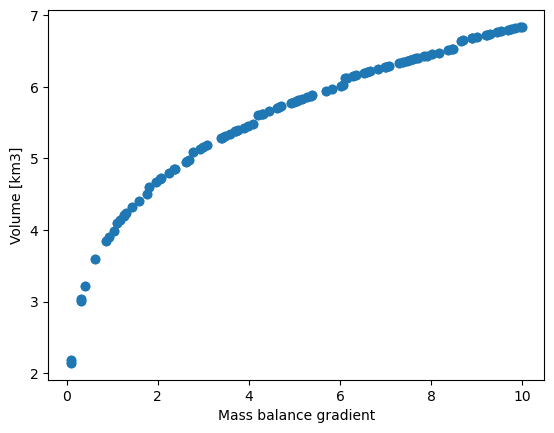

In [66]:
plt.scatter(param_values, sobol_runs.summary()["Volume [km3]"])
plt.xlabel("Mass balance gradient")
plt.ylabel("Volume [km3]")

What to we see here?

* more evently spaced samples
* the same conclustions as with the somple OAT approach.

Now we can actually analyse the Sobol Sensitivity measures:

In [67]:
sobol_result = analyze(problem, sobol_runs.summary()["Volume [km3]"].values)

In [68]:
sobol_result

{'S1': array([1.06365291]),
 'S1_conf': array([0.41396761]),
 'ST': array([1.0385048]),
 'ST_conf': array([0.28813829]),
 'S2': array([[nan]]),
 'S2_conf': array([[nan]])}

What do the values mean?

* S1 is the first-order sensitivity index and should be between 0 and 1
* S1 is larger than 1 => might need more samples. In this case it should be 1 since all the Variance of the output is form one input (the mass balance gradient)
* S1_conf quite large so significant uncertainties about the S1

* ST the Total Sensitivity Index sould also be 1 and the same is S1 since ther are not interactions with other variables

* S2 has a  not a number value (nan), since we only had one paramter.

So sobol sensitivity for one varialbe gives not much more insight then OTA, but now lets try it for multiple inputs


## Sobol sensitivity for multiple inputs

In [69]:
def evaluate_model_multi(mb_gradient, ela_width, add_to_with_at_top):
    top = 5000
    bottom = 0

    accumulation_fraction = 1 / 3
    ela_alt = (top - bottom) * (1 - accumulation_fraction)
    top_width = ela_width + add_to_with_at_top
    bed = GlacierBed(
        altitudes=[top, ela_alt, bottom],
        widths=[top_width, ela_width, ela_width],
        map_dx=200,
    )
    mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)
    glacier = Glacier(bed, mass_balance=mass_balance)
    glacier.progress_to_equilibrium()
    return glacier

In [70]:
problem = {
    "num_vars": 3,
    "names": ["mb_gradient", "ela_width", "add_to_with_at_top"],
    "bounds": [
        [0.01, 10],
        [500, 2000],
        [0, 1000],
    ],
}

In [71]:
number_of_samples = 50

In [72]:
param_values = sample(problem, number_of_samples)

/opt/conda/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [73]:
results = []
for forcing in param_values:
    glacier = evaluate_model_multi(
        mb_gradient=forcing[0], ela_width=forcing[1], add_to_with_at_top=forcing[2]
    )
    results.append(glacier)
    print(f"Done with forcings: {forcing}")

Done with forcings: [   8.3268954  1554.79160044  767.97583979]
Done with forcings: [   3.58159846 1554.79160044  767.97583979]
Done with forcings: [  8.3268954  710.24285257 767.97583979]
Done with forcings: [   8.3268954  1554.79160044  860.35053618]
Done with forcings: [  8.3268954  710.24285257 860.35053618]
Done with forcings: [   3.58159846 1554.79160044  860.35053618]
Done with forcings: [  3.58159846 710.24285257 767.97583979]
Done with forcings: [  3.58159846 710.24285257 860.35053618]
Done with forcings: [  4.56549055 919.9620178  168.90874784]
Done with forcings: [  7.10130877 919.9620178  168.90874784]
Done with forcings: [   4.56549055 1811.89112179  168.90874784]
Done with forcings: [  4.56549055 919.9620178  140.52754641]
Done with forcings: [   4.56549055 1811.89112179  140.52754641]
Done with forcings: [  7.10130877 919.9620178  140.52754641]
Done with forcings: [   7.10130877 1811.89112179  168.90874784]
Done with forcings: [   7.10130877 1811.89112179  140.52754641]


In [74]:
sobol_results_multi = GlacierCollection(results)

In [75]:
sobol_results_multi

,Id,Type,Age,Length [m],Area [km2],Volume [km3],Max ice thickness [m],Max ice velocity [m/yr],AAR [%],Response time [yrs],...,Basal sliding,Bed type,Top [m],Bottom [m],Width(s) [m],Length [km],ELA [m],Original ELA [m],Temperature bias [C],Gradient [mm/m/yr]
Glacier,,,,,,,,,,,,,,,,,,,,,
1,404,Glacier,113,33600.0,57.386436,17.206609,340.116537,930.157103,52.315679,NaN,...,0,Linear bed with a variable width,5000,0,"[2322.7674402296543, 1554.7916004434228, 1554....",40.0,3333.333333,3333.333333,0,8.326895
2,405,Glacier,208,32800.0,56.142603,14.114528,284.929218,465.242645,52.366983,NaN,...,0,Linear bed with a variable width,5000,0,"[2322.7674402296543, 1554.7916004434228, 1554....",40.0,3333.333333,3333.333333,0,3.581598
3,406,Glacier,106,35800.0,30.572132,9.444284,356.347730,1107.976525,54.465852,NaN,...,0,Linear bed with a variable width,5000,0,"[1478.218692354858, 710.2428525686264, 710.242...",40.0,3333.333333,3333.333333,0,8.326895
4,407,Glacier,110,33800.0,58.316305,17.556967,341.914753,939.391904,52.542791,NaN,...,0,Linear bed with a variable width,5000,0,"[2415.1421366259456, 1554.7916004434228, 1554....",40.0,3333.333333,3333.333333,0,8.326895
5,408,Glacier,113,36800.0,31.901286,9.933627,361.136683,1148.246345,54.136636,NaN,...,0,Linear bed with a variable width,5000,0,"[1570.5933887511492, 710.2428525686264, 710.24...",40.0,3333.333333,3333.333333,0,8.326895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,799,Glacier,199,31600.0,39.820885,10.047819,283.382461,451.428841,51.443665,NaN,...,0,Linear bed with a variable width,5000,0,"[1452.226341702044, 1208.4726402536035, 1208.4...",40.0,3333.333333,3333.333333,0,4.027151
397,800,Glacier,204,31600.0,42.067922,10.596702,283.044473,452.878153,51.332746,NaN,...,0,Linear bed with a variable width,5000,0,"[1523.3351113274693, 1279.5814098790288, 1279....",40.0,3333.333333,3333.333333,0,4.027151
398,801,Glacier,146,32000.0,40.304274,11.119177,310.108395,641.873516,51.426351,NaN,...,0,Linear bed with a variable width,5000,0,"[1452.226341702044, 1208.4726402536035, 1208.4...",40.0,3333.333333,3333.333333,0,6.182327


Lets now blot the mass balance gradient and volume

Text(0, 0.5, 'Volume [km3]')

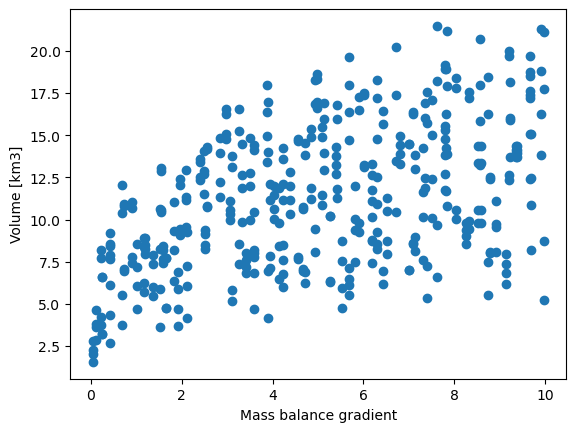

In [76]:
mb_gradients = param_values[:, 0]
plt.scatter(mb_gradients, sobol_results_multi.summary()["Volume [km3]"])
plt.xlabel("Mass balance gradient")
plt.ylabel("Volume [km3]")

What do we see here?

* there is much mor variation in total
* not just depending on the Mass balance gradient
* The OTA relation ship is still visible

Lets look at the other values

Text(0, 0.5, 'Volume [km3]')

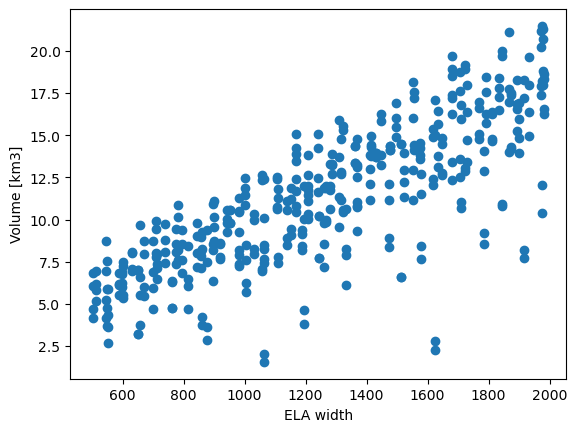

In [77]:
ela_widths = param_values[:, 1]
plt.scatter(ela_widths, sobol_results_multi.summary()["Volume [km3]"])
plt.xlabel("ELA width")
plt.ylabel("Volume [km3]")

* looks like a linear relationship and interactions with other iputs
* not supprising the wider the glacier is at the larger it is, but it is not the only relevant intput

Text(0, 0.5, 'Volume [km3]')

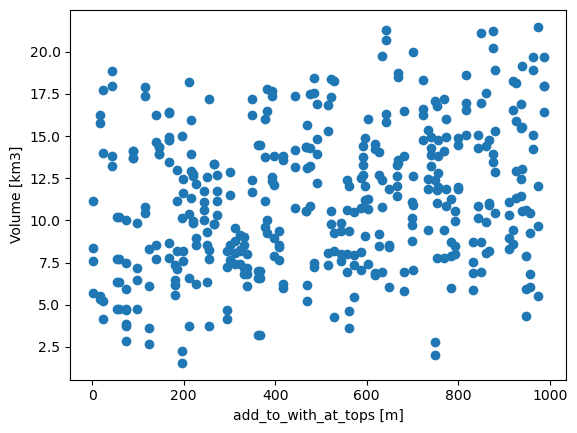

In [104]:
add_to_with_at_tops = param_values[:, 2]
plt.scatter(add_to_with_at_tops, sobol_results_multi.summary()["Volume [km3]"])
plt.xlabel("add_to_with_at_tops [m]")
plt.ylabel("Volume [km3]")

* All over the place, looks like no stron correlation

In [79]:
sobol_multi = analyze(problem, sobol_results_multi.summary()["Volume [km3]"].values)

In [80]:
total_Si, first_Si, second_Si = sobol_multi.to_df()

In [81]:
total_Si

,ST,ST_conf
mb_gradient,0.318980,0.144315
ela_width,0.686483,0.272084
add_to_with_at_top,0.066631,0.025187


In [82]:
total_Si.sum()

ST         1.072094
ST_conf    0.441586
dtype: float64

Total Effect:

So the largest total effect comes form the ELA with, followed by the mb_gradient.
the added glacier witha the top as a rather small effect.
Although note theat eh confidence intervall is rather larger, which ist moste likely du to the small sample size.

In [83]:
first_Si

,S1,S1_conf
mb_gradient,0.358234,0.249269
ela_width,0.659353,0.260511
add_to_with_at_top,-0.017496,0.096155


S1 effect:

The S1 index represents the direct effect of each input parameter on the output variance, without considering any interaction effects.
The ranking is the same as for the ST

In [84]:
second_Si

,S2,S2_conf
"(mb_gradient, ela_width)",0.020059,0.468036
"(mb_gradient, add_to_with_at_top)",-0.033717,0.403168
"(ela_width, add_to_with_at_top)",-0.005662,0.356294


S2 effect

Mass balance gradient and add with to topa interact the most. Likely toto a larger accumulation area when the with at the top is larger and therfore the mass balance gradient has a larger effect.
The S2 conf values are quite high, so the conclusions need to be taken with a caution. A larger number of samples would be a good start to investigate this futher and see if it reduces the S2_conf values.

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

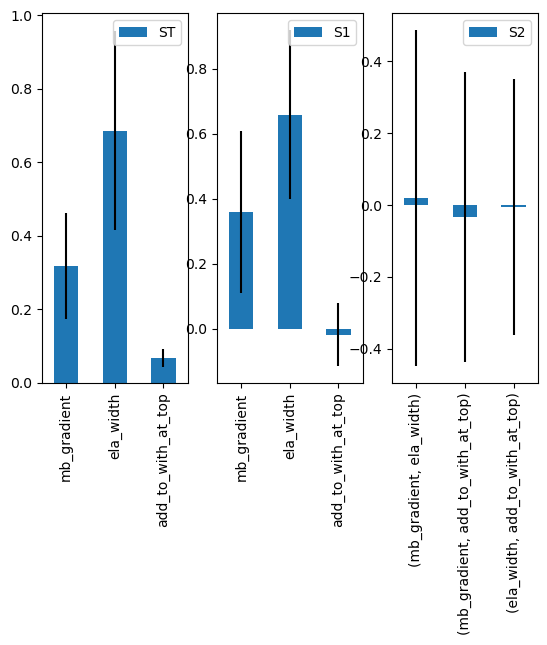

In [85]:
sobol_multi.plot()

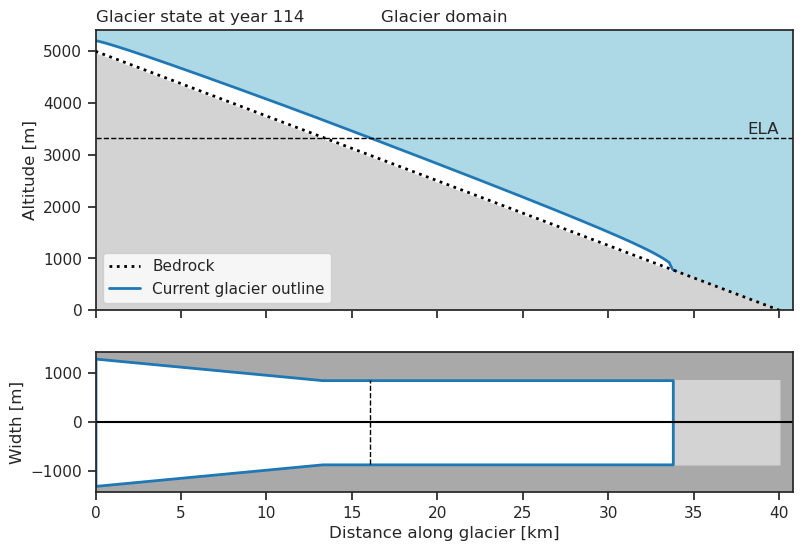

In [103]:
sobol_results_multi.glaciers[150].plot()